# ADS 509 Assignment 5.1: Topic Modeling
## Halee Staggs
### ChatGPT4.o was used as a tool for this assignment. All code was verified for accuracy. 
### The code repository for this course's text book was also used as a resource for the training and data visualization of the SVD and LDA models: https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb 

In [11]:
#!pip install pyLDAvis==3.4.1
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [14]:
import nltk
nltk.download('brown')

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\halee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


In [15]:
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [16]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [17]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [18]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

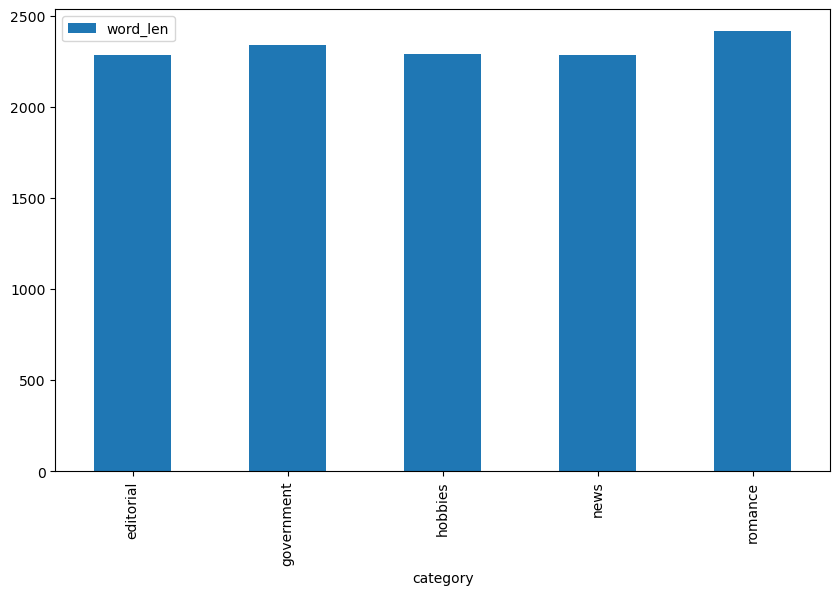

In [19]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [20]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\halee\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [30]:
print(count_text_vectors[0])

  (0, 381)	4
  (0, 3967)	3
  (0, 643)	1
  (0, 2030)	9
  (0, 1987)	3
  (0, 4546)	1
  (0, 3206)	1
  (0, 403)	1
  (0, 1151)	4
  (0, 4301)	1
  (0, 1207)	3
  (0, 1718)	1
  (0, 2274)	1
  (0, 3893)	2
  (0, 2420)	3
  (0, 2804)	1
  (0, 2042)	1
  (0, 1231)	2
  (0, 3795)	1
  (0, 3491)	6
  (0, 1494)	1
  (0, 1874)	2
  (0, 2193)	1
  (0, 329)	2
  (0, 648)	6
  :	:
  (0, 696)	1
  (0, 4602)	1
  (0, 212)	2
  (0, 3272)	2
  (0, 1701)	2
  (0, 1114)	1
  (0, 174)	1
  (0, 3927)	1
  (0, 4364)	2
  (0, 3448)	1
  (0, 4134)	1
  (0, 1340)	1
  (0, 3370)	1
  (0, 425)	1
  (0, 905)	1
  (0, 4260)	1
  (0, 2517)	1
  (0, 665)	1
  (0, 4229)	1
  (0, 3139)	1
  (0, 2929)	1
  (0, 194)	1
  (0, 3926)	1
  (0, 3510)	1
  (0, 3368)	1


In [21]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

C:\Users\halee\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [29]:
print(tfidf_text_vectors[0])

  (0, 3368)	0.014202153371640824
  (0, 3510)	0.020879332532565246
  (0, 3926)	0.022325916789103336
  (0, 194)	0.031314681027674846
  (0, 2929)	0.027650303215677303
  (0, 3139)	0.033003867148170336
  (0, 4229)	0.030582245182981187
  (0, 665)	0.032116973721665935
  (0, 2517)	0.020036859800329522
  (0, 4260)	0.020660678627945756
  (0, 905)	0.019271086478280658
  (0, 425)	0.030582245182981187
  (0, 3370)	0.024747538754292486
  (0, 1340)	0.020036859800329522
  (0, 4134)	0.019090053650940745
  (0, 3448)	0.026714038961253943
  (0, 4364)	0.03713840987894748
  (0, 3927)	0.028703889258166387
  (0, 174)	0.032116973721665935
  (0, 1114)	0.02286918282947769
  (0, 1701)	0.06423394744333187
  (0, 3272)	0.03891219673195628
  (0, 212)	0.04949507750858497
  (0, 4602)	0.026282267292977238
  (0, 696)	0.025479974598986144
  :	:
  (0, 648)	0.1484852325257549
  (0, 329)	0.06799065929296147
  (0, 2193)	0.033995329646480735
  (0, 1874)	0.043631193573977205
  (0, 1494)	0.021815596786988602
  (0, 3491)	0.0864299

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count_text_vectors include the word frequency for each word contained in each row of text data. tfidf_text_vectors includes the tf_idf values for each word contained in each row of text data.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [31]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [32]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 

In [38]:
# Assign each document to the most relevant topic
df["topic"] = np.argmax(W_text_matrix, axis=1)

# Tally the Brown categories for each topic
n_topics = 5
tally_results = {}
for topic in range(n_topics):
    topic_docs = df[df["topic"] == topic]["category"]
    tally_results[topic] = Counter(topic_docs)

# Display the tally results
for topic, tally in tally_results.items():
    print(f"Topic {topic:02d}")
    for category, count in tally.items():
        print(f"  {category} ({count})")
    print()

# Interpret the results by comparing the original categories with NMF topics
for topic_idx, topic in enumerate(H_text_matrix):
    print(f"Topic {topic_idx:02d}")
    print(" ".join([tfidf_text_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6 - 1:-1]]))
    for category, count in tally_results[topic_idx].items():
        print(f"  {category}: {count}")
    print()

Topic 00
  editorial (20)
  government (4)
  news (8)

Topic 01
  editorial (4)
  romance (29)
  hobbies (8)

Topic 02
  editorial (2)
  government (26)
  news (11)
  hobbies (26)

Topic 03
  news (17)
  hobbies (1)

Topic 04
  editorial (1)
  news (8)
  hobbies (1)

Topic 00
mr president kennedy united khrushchev berlin
  editorial: 20
  government: 4
  news: 8

Topic 01
said didn ll thought man don
  editorial: 4
  romance: 29
  hobbies: 8

Topic 02
state development tax sales program 1960
  editorial: 2
  government: 26
  news: 11
  hobbies: 26

Topic 03
mrs mr said miss car jr
  news: 17
  hobbies: 1

Topic 04
game league ball baseball team runs
  editorial: 1
  news: 8
  hobbies: 1



Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The model has some interpretable information, but it does show a lot of overlap between topics based on language, and some topics don't make sense based on the input categories. Topic00 makes sense because president's names will be dispersed across editorials, government, and news. Topic01 is primarily based on romance, but the primary words making up the topic do not provide interpretable information. Topic02 has 26 hobbies documents that it used which does not really make sense since the language primarly involves government terms. Topic03 uses primarily name titles from news sources, which shows that news sources are using more formal language, but does not imply the subject matter of the news. Topic04 is about sports, and is the most interpretable since it comes mostly from news. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [39]:
svd_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

In [43]:
svd_para_model.singular_values_

array([3.70145447, 2.25514643, 1.69735202, 1.66198175, 1.55995291])

In [44]:
# Assign each document to the most relevant topic
df["topic_svd"] = np.argmax(W_svd_para_matrix, axis=1)

# Tally the Brown categories for each topic
n_topics = 5
tally_results = {}
for topic in range(n_topics):
    topic_docs = df[df["topic_svd"] == topic]["category"]
    tally_results[topic] = Counter(topic_docs)

# Display the tally results
for topic, tally in tally_results.items():
    print(f"Topic {topic:02d}")
    for category, count in tally.items():
        print(f"  {category} ({count})")
    print()

# Interpret the results by comparing the original categories with NMF topics
for topic_idx, topic in enumerate(H_svd_para_matrix):
    print(f"Topic {topic_idx:02d}")
    print(" ".join([tfidf_text_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6 - 1:-1]]))
    for category, count in tally_results[topic_idx].items():
        print(f"  {category}: {count}")
    print()

Topic 00
  editorial (27)
  government (30)
  news (34)
  romance (21)
  hobbies (36)

Topic 01
  romance (8)

Topic 02

Topic 03
  news (3)

Topic 04
  news (7)

Topic 00
said mr mrs state man president
  editorial: 27
  government: 30
  news: 34
  romance: 21
  hobbies: 36

Topic 01
said ll didn thought got mrs
  romance: 8

Topic 02
mrs mr said kennedy president laos

Topic 03
mrs club game jr dallas home
  news: 3

Topic 04
game league baseball ball team runs
  news: 7



Q: How does your five-topic LSA model compare to the original Brown categories? 

A: This model is giving too much weight to topic00 and does not assign any data to topic02. The language uses to define each topic has a lot of overlap and does not make sense. The only interpretable topic is #4 which has news about sports. 

In [42]:
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: What is your interpretation of the display topics output? 

A: Topic00, topic01, topi04 are not well defined since most of the words are contributing a similar amount of information to the topic. Topic03 appears to have a primary topic word, but the word is not indicative of the underlying topic data. Seeing the contribution of each word makes sense given the underlying document sample size in each topic. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [45]:
# Fit your LDA model here
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(df["text"])
count_para_vectors.shape

C:\Users\halee\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [46]:
lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [47]:
# Call `display_topics` on your fitted model here
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


In [48]:
# Assign each document to the most relevant topic
df["topic_lda"] = np.argmax(W_lda_para_matrix, axis=1)

# Tally the Brown categories for each topic
n_topics = 5
tally_results = {}
for topic in range(n_topics):
    topic_docs = df[df["topic_lda"] == topic]["category"]
    tally_results[topic] = Counter(topic_docs)

# Display the tally results
for topic, tally in tally_results.items():
    print(f"Topic {topic:02d}")
    for category, count in tally.items():
        print(f"  {category} ({count})")
    print()

# Interpret the results by comparing the original categories with NMF topics
for topic_idx, topic in enumerate(H_lda_para_matrix):
    print(f"Topic {topic_idx:02d}")
    print(" ".join([count_para_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6 - 1:-1]]))
    for category, count in tally_results[topic_idx].items():
        print(f"  {category}: {count}")
    print()

Topic 00
  editorial (3)
  news (9)
  hobbies (16)

Topic 01
  editorial (1)
  government (20)
  news (3)
  hobbies (14)

Topic 02
  editorial (22)
  government (2)
  news (31)
  hobbies (1)

Topic 03
  government (8)
  news (1)
  hobbies (3)

Topic 04
  editorial (1)
  romance (29)
  hobbies (2)

Topic 00
home right game way set place
  editorial: 3
  news: 9
  hobbies: 16

Topic 01
state development states program use fiscal
  editorial: 1
  government: 20
  news: 3
  hobbies: 14

Topic 02
said mr president state mrs 000
  editorial: 22
  government: 2
  news: 31
  hobbies: 1

Topic 03
feed general business property shall government
  government: 8
  news: 1
  hobbies: 3

Topic 04
said man little old good know
  editorial: 1
  romance: 29
  hobbies: 2



Q: What inference do you draw from the displayed topics for your LDA model? 

A: The topics produced from the LDA model are a lot cleaner than the other methods. There is a nice balance of contribution from each word for the topics. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The topics produced from the LDA model are a lot cleaner than the other methods. The underlying number of topic documents make sense for the given list of words that make up each LDA topic. Topic00 could be hobbies, topic01 could be government/editorial, topc02 could be editorial/news, topic03 is could be government, topic04 could be romance. It appears that editorial has overlap with government and news, but other topics have a more distinguishable language using LDA. 

In [50]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [51]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The PCA visualization shows the clear separation of topic 1 and 5 from the other three topics. There is strong overlap between topics 2 and 4, which makes sense since they are both composed of primarily government documents. Topic 2 has a small overlap with topic 3 which is likely due to the news word, but its small enough that topic 3 can be considered a separate topic. I would consider topic 2 and 4 as one topic, and collapse the model into 4 topics instead of 5. As for the salient terms graphs, strong topics will show a rapid decline in the red bar term frequencies. This pattern can be seen with topic 5. Moderate decline is seen in topic 3 and topic 2. Topics 1 and 4 show the least decline which is probably due to the considerable overlap between two categories in the underlying data, and the fact that the underlying document sample sizes are small. The topic with more clear subject matter have larger underlying sample sizes.  